In [27]:
# Regression Analysis: Logistic Regression
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, roc_curve

=== Logistic Regression Model Summary ===
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      196
Method:                           MLE   Df Model:                            3
Date:                Fri, 14 Feb 2025   Pseudo R-squ.:                  0.4076
Time:                        10:24:24   Log-Likelihood:                -68.510
converged:                       True   LL-Null:                       -115.64
Covariance Type:            nonrobust   LLR p-value:                 2.652e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4212      1.001     -2.419      0.016      -4.383      -0.459
X1             1.0060      0.168      5.971      0.000       0.676       1.336
X2        

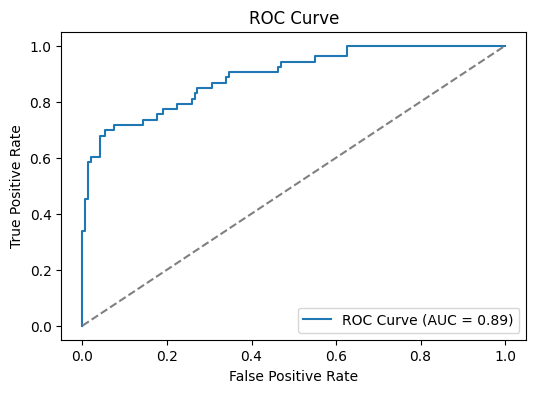


=== 95% Confidence Intervals for Coefficients ===
               2.5%     97.5%
Intercept -4.383138 -0.459176
X1         0.675753  1.336150
X2        -0.668946 -0.298874
X3         0.806580  2.653600


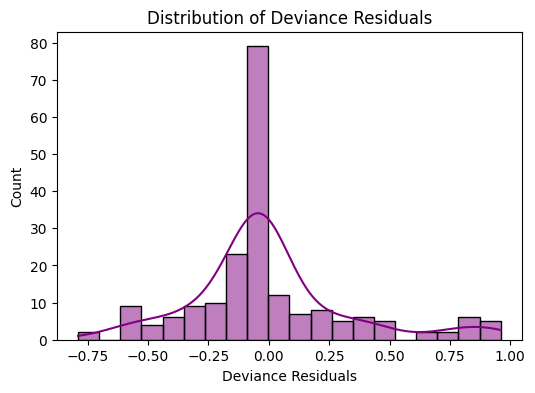

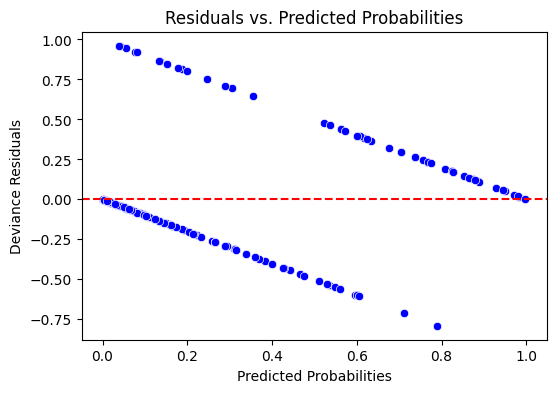

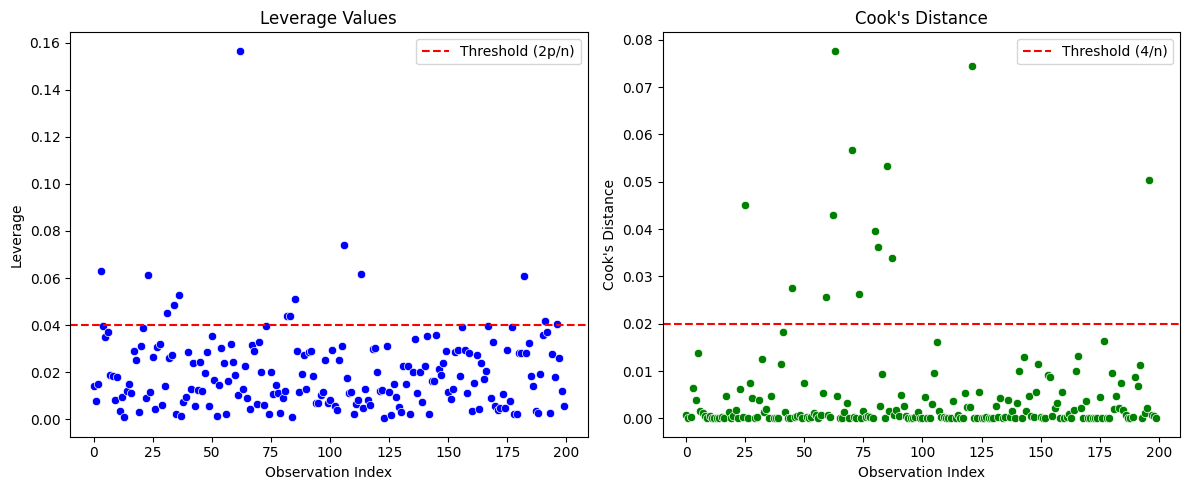


=== Correlation Matrix of Predictors ===
          X1        X2        X3
X1  1.000000  0.095147  0.001037
X2  0.095147  1.000000 -0.030619
X3  0.001037 -0.030619  1.000000

=== Class Distribution ===
y
0.0    147
1.0     53
Name: count, dtype: int64

=== Final Decision ===
Decision: The logistic regression model is performing adequately.


In [33]:
# 1. Data Simulation & Preparation
# ---------------------------
np.random.seed(42)
n = 200  # number of observations

# Simulate two continuous predictors and one binary predictor
X1 = np.random.normal(5, 2, n)      # continuous predictor 1
X2 = np.random.normal(10, 3, n)     # continuous predictor 2
X3 = np.random.binomial(1, 0.4, n)  # binary predictor (e.g., gender, 0 or 1)

# True model coefficients for simulation
beta0_true = -1.0
beta1_true = 0.8
beta2_true = -0.5
beta3_true = 1.2

# Linear predictor (logit) and probability via sigmoid
lin_pred = beta0_true + beta1_true * X1 + beta2_true * X2 + beta3_true * X3
prob = 1 / (1 + np.exp(-lin_pred))

# Generate binary outcome y
y = np.random.binomial(1, prob, n)

# Create DataFrame and ensure numeric types
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
# Add constant for intercept
df['Intercept'] = 1.0

# Define predictor columns and response
predictors = ['Intercept', 'X1', 'X2', 'X3']
X = df[predictors].astype(float)
y = df['y'].astype(float)

# ---------------------------
# 2. Fit Logistic Regression Model (MLE via Logit)
# ---------------------------
logit_model = sm.Logit(y, X).fit(disp=False)  # disp=False suppresses output
print("=== Logistic Regression Model Summary ===")
print(logit_model.summary())

# ---------------------------
# 3. Compute Predictions & Goodness-of-Fit Metrics
# ---------------------------
# Predicted probabilities
y_pred_prob = logit_model.predict(X)

# Predicted classes based on threshold 0.5
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Compute ROC-AUC and Accuracy
roc_auc = roc_auc_score(y, y_pred_prob)
accuracy = np.mean(y_pred_class == y)
conf_matrix = confusion_matrix(y, y_pred_class)

print("\n=== Model Performance ===")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ---------------------------
# 4. Inference: Confidence Intervals & Wald Tests
# ---------------------------
conf_int = logit_model.conf_int(alpha=0.05)
conf_int.columns = ["2.5%", "97.5%"]
print("\n=== 95% Confidence Intervals for Coefficients ===")
print(conf_int)

# (Wald tests are provided in the summary output.)

# ---------------------------
# 5. Model Diagnostics: Residual Analysis & Influence Measures
# ---------------------------
# Deviance Residuals
deviance_resid = logit_model.resid_generalized
plt.figure(figsize=(6, 4))
sns.histplot(deviance_resid, bins=20, kde=True, color='purple')
plt.xlabel("Deviance Residuals")
plt.title("Distribution of Deviance Residuals")
plt.show()

# Plot residuals vs. predicted probabilities to check for patterns
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_prob, y=deviance_resid, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Probabilities")
plt.ylabel("Deviance Residuals")
plt.title("Residuals vs. Predicted Probabilities")
plt.show()

# Influence Measures: Leverage and Cook's Distance
influence = logit_model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=np.arange(n), y=leverage, color='blue')
plt.xlabel("Observation Index")
plt.ylabel("Leverage")
plt.title("Leverage Values")
plt.axhline(y=2*X.shape[1]/n, color='red', linestyle='--', label="Threshold (2p/n)")
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(x=np.arange(n), y=cooks_d, color='green')
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.axhline(y=4/n, color='red', linestyle='--', label="Threshold (4/n)")
plt.legend()

plt.tight_layout()
plt.show()

# ---------------------------
# 6. Identify Issues: Multicollinearity & Class Imbalance
# ---------------------------
# Multicollinearity: Check Correlation Matrix of Predictors
corr_matrix = X.drop("Intercept", axis=1).corr()
print("\n=== Correlation Matrix of Predictors ===")
print(corr_matrix)

# Check class balance
class_counts = y.value_counts()
print("\n=== Class Distribution ===")
print(class_counts)

# ---------------------------
# 7. Final Decision
# ---------------------------
print("\n=== Final Decision ===")
if roc_auc >= 0.7 and accuracy >= 0.7:
    print("Decision: The logistic regression model is performing adequately.")
else:
    print("Decision: Consider revising the model or addressing potential issues (e.g., class imbalance).")

         X1         X2  X3     Logit  Probability  Log-Odds
0  5.993428  11.073362   0 -1.741938     0.149067 -1.741938
1  4.723471  11.682354   0 -3.062400     0.044685 -3.062400
2  6.295377  13.249154   0 -2.588275     0.069897 -2.588275
3  8.046060  13.161406   1  0.056145     0.514032  0.056145
4  4.531693   5.866992   1  0.891859     0.709274  0.891859
   Probability  Predicted Class                                 Decision
0     0.149067                0  Accept H0 (No Significant Relationship)
1     0.044685                0  Accept H0 (No Significant Relationship)
2     0.069897                0  Accept H0 (No Significant Relationship)
3     0.514032                1     Accept H1 (Significant Relationship)
4     0.709274                1     Accept H1 (Significant Relationship)


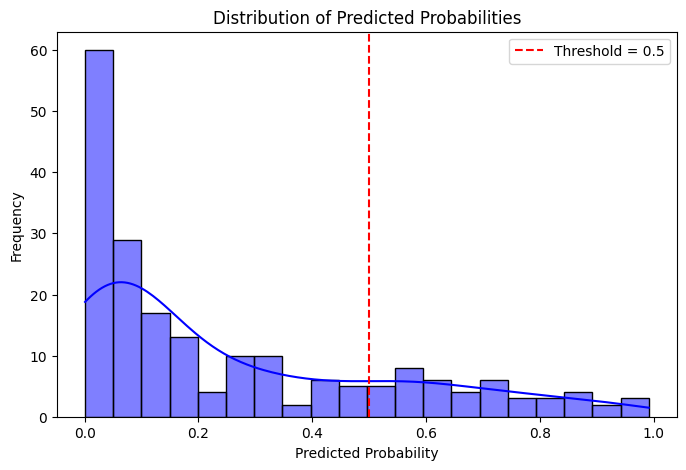

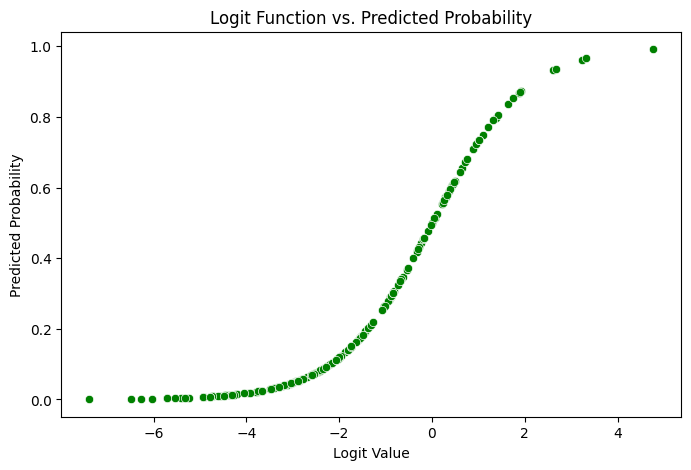

In [34]:
# Flow 1: Logistic Model Formulation
# 1. Data Simulation & Preparation (Referencing Main LR Flow)
# ---------------------------
n = 200  # Number of observations
np.random.seed(42)

X1 = np.random.normal(5, 2, n)      # Continuous predictor 1
X2 = np.random.normal(10, 3, n)     # Continuous predictor 2
X3 = np.random.binomial(1, 0.4, n)  # Binary predictor

# True model coefficients
beta0_true = -1.0
beta1_true = 0.8
beta2_true = -0.5
beta3_true = 1.2

# ---------------------------
# 2. Transform Linear Model to Logit Function
# ---------------------------
def logit_function(X1, X2, X3, beta0, beta1, beta2, beta3):
    return beta0 + beta1 * X1 + beta2 * X2 + beta3 * X3

logit_values = logit_function(X1, X2, X3, beta0_true, beta1_true, beta2_true, beta3_true)

# ---------------------------
# 3. Apply Sigmoid Function
# ---------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

probabilities = sigmoid(logit_values)

# ---------------------------
# 4. Compute Log-Odds & Probability
# ---------------------------
log_odds = np.log(probabilities / (1 - probabilities))  # Logit transformation

# Store results in DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'Logit': logit_values, 'Probability': probabilities, 'Log-Odds': log_odds})
print(df.head())

# ---------------------------
# 5. Decision Based on Probability
# ---------------------------
thresh = 0.5
df['Predicted Class'] = (df['Probability'] >= thresh).astype(int)

def model_decision(prob):
    return "Accept H1 (Significant Relationship)" if prob >= thresh else "Accept H0 (No Significant Relationship)"

df['Decision'] = df['Probability'].apply(model_decision)
print(df[['Probability', 'Predicted Class', 'Decision']].head())

# ---------------------------
# 6. Visualizations
# ---------------------------
plt.figure(figsize=(8, 5))
sns.histplot(df['Probability'], bins=20, kde=True, color='blue')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Logit'], y=df['Probability'], color='green')
plt.xlabel("Logit Value")
plt.ylabel("Predicted Probability")
plt.title("Logit Function vs. Predicted Probability")
plt.show()

In [35]:
# Flow 2: Parameter Estimation (MLE & Odds Ratio)
from scipy.optimize import minimize

# ---------------------------
# 1. Simulate Data (Interrelated with Main LR Flow)
# ---------------------------
np.random.seed(42)
n = 200  # Number of observations

# Generate predictors
X1 = np.random.normal(5, 2, n)      # Continuous predictor 1
X2 = np.random.normal(10, 3, n)     # Continuous predictor 2
X3 = np.random.binomial(1, 0.4, n)  # Binary predictor

# True coefficients (for simulation)
beta0_true = -1.0
beta1_true = 0.8
beta2_true = -0.5
beta3_true = 1.2

# Compute logit and probabilities
lin_pred = beta0_true + beta1_true * X1 + beta2_true * X2 + beta3_true * X3
prob = 1 / (1 + np.exp(-lin_pred))

# Generate binary outcome
y = np.random.binomial(1, prob, n)

# Create DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
df['Intercept'] = 1.0  # Add intercept column

# Prepare X matrix and response variable
predictors = ["Intercept", "X1", "X2", "X3"]
X = df[predictors].values
y = df["y"].values

# ---------------------------
# 2. Compute Log Likelihood Function
# ---------------------------
def log_likelihood(beta, X, y):
    """
    Compute the log-likelihood for logistic regression.
    """
    linear_pred = np.dot(X, beta)
    log_likelihood_value = np.sum(y * linear_pred - np.log(1 + np.exp(linear_pred)))
    return -log_likelihood_value  # Negative because we minimize

# Initial beta coefficients (zero initialization)
beta_init = np.zeros(X.shape[1])

# ---------------------------
# 3. Optimize Log Likelihood using Newton-Raphson
# ---------------------------
opt_result = minimize(log_likelihood, beta_init, args=(X, y), method='BFGS')
beta_estimated = opt_result.x  # Estimated coefficients

print("\n=== Estimated Regression Coefficients ===")
for i, col in enumerate(predictors):
    print(f"{col}: {beta_estimated[i]:.4f}")

# ---------------------------
# 4. Compute Odds Ratio
# ---------------------------
odds_ratios = np.exp(beta_estimated)  # Exponentiate coefficients to get OR

print("\n=== Odds Ratios ===")
for i, col in enumerate(predictors):
    print(f"{col}: {odds_ratios[i]:.4f}")

# ---------------------------
# 5. Final Decision
# ---------------------------
print("\n=== Final Decision ===")
if all(odds_ratios >= 1):  
    print("Decision: All predictors increase the odds; consider refining for significance testing.")
else:
    print("Decision: Some predictors reduce the odds; investigate further.")


=== Estimated Regression Coefficients ===
Intercept: -2.4212
X1: 1.0060
X2: -0.4839
X3: 1.7301

=== Odds Ratios ===
Intercept: 0.0888
X1: 2.7345
X2: 0.6164
X3: 5.6412

=== Final Decision ===
Decision: Some predictors reduce the odds; investigate further.


In [36]:
# Flow 3: Model Evaluation (Goodness of Fit & Metrics)
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import chi2

# ---------------------------
# 1. Simulate Data (Interrelated with Main LR Flow)
# ---------------------------
np.random.seed(42)
n = 200  # Number of observations

# Generate predictors
X1 = np.random.normal(5, 2, n)      # Continuous predictor 1
X2 = np.random.normal(10, 3, n)     # Continuous predictor 2
X3 = np.random.binomial(1, 0.4, n)  # Binary predictor

# True coefficients (for simulation)
beta0_true = -1.0
beta1_true = 0.8
beta2_true = -0.5
beta3_true = 1.2

# Compute logit and probabilities
lin_pred = beta0_true + beta1_true * X1 + beta2_true * X2 + beta3_true * X3
prob = 1 / (1 + np.exp(-lin_pred))

# Generate binary outcome
y = np.random.binomial(1, prob, n)

# Create DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
df['Intercept'] = 1.0  # Add intercept column

# Prepare X matrix and response variable
predictors = ["Intercept", "X1", "X2", "X3"]
X = df[predictors].values
y = df["y"].values

# ---------------------------
# 2. Fit Logistic Regression Model
# ---------------------------
model = sm.Logit(y, X).fit()
y_pred_prob = model.predict(X)
y_pred = (y_pred_prob >= 0.5).astype(int)

# ---------------------------
# 3. Compute ROC-AUC & Confusion Matrix
# ---------------------------
auc_score = roc_auc_score(y, y_pred_prob)
conf_matrix = confusion_matrix(y, y_pred)

print("\n=== Model Evaluation ===")
print(f"ROC-AUC Score: {auc_score:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# ---------------------------
# 4. Compute Accuracy, Precision, Recall, F1-Score
# ---------------------------
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("\n=== Classification Metrics ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ---------------------------
# 5. Perform Hosmer-Lemeshow Test
# ---------------------------
def hosmer_lemeshow_test(y, y_pred_prob, g=10):
    """
    Perform the Hosmer-Lemeshow goodness-of-fit test.
    """
    df = pd.DataFrame({'y': y, 'y_prob': y_pred_prob})
    df['decile'] = pd.qcut(df['y_prob'], g, labels=False)

    observed = df.groupby('decile')['y'].sum()
    expected = df.groupby('decile')['y_prob'].sum()

    hl_stat = np.sum(((observed - expected) ** 2) / (expected * (1 - expected / g)))
    p_value = 1 - chi2.cdf(hl_stat, g - 2)
    
    return hl_stat, p_value

hl_stat, hl_p_value = hosmer_lemeshow_test(y, y_pred_prob)
print("\n=== Hosmer-Lemeshow Test ===")
print(f"HL Statistic: {hl_stat:.4f}")
print(f"P-value: {hl_p_value:.4f}")

# ---------------------------
# 6. Perform Deviance Test
# ---------------------------
deviance = -2 * model.llf
p_value_dev = 1 - chi2.cdf(deviance, df.shape[1] - 1)

print("\n=== Deviance Test ===")
print(f"Deviance: {deviance:.4f}")
print(f"P-value: {p_value_dev:.4f}")

# ---------------------------
# 7. Final Decision
# ---------------------------
print("\n=== Final Decision ===")
if auc_score > 0.7 and hl_p_value > 0.05:
    print("Decision: Model has a good fit and strong predictive power.")
else:
    print("Decision: Model may require improvement or additional predictors.")

Optimization terminated successfully.
         Current function value: 0.342552
         Iterations 7

=== Model Evaluation ===
ROC-AUC Score: 0.8923
Confusion Matrix:
[[135  12]
 [ 15  38]]

=== Classification Metrics ===
Accuracy: 0.8650
Precision: 0.7600
Recall: 0.7170
F1-Score: 0.7379

=== Hosmer-Lemeshow Test ===
HL Statistic: 52.3958
P-value: 0.0000

=== Deviance Test ===
Deviance: 137.0209
P-value: 0.0000

=== Final Decision ===
Decision: Model may require improvement or additional predictors.


In [38]:
# Flow 4: Inference & Hypothesis Testing
# 1. Simulate Data (Interrelated with Main LR Flow)
# ---------------------------
np.random.seed(42)
n = 200  # Number of observations

# Generate predictors
X1 = np.random.normal(5, 2, n)      # Continuous predictor 1
X2 = np.random.normal(10, 3, n)     # Continuous predictor 2
X3 = np.random.binomial(1, 0.4, n)  # Binary predictor

# True coefficients (for simulation)
beta0_true = -1.0
beta1_true = 0.8
beta2_true = -0.5
beta3_true = 1.2

# Compute logit and probabilities
lin_pred = beta0_true + beta1_true * X1 + beta2_true * X2 + beta3_true * X3
prob = 1 / (1 + np.exp(-lin_pred))

# Generate binary outcome
y = np.random.binomial(1, prob, n)

# Create DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
df['Intercept'] = 1.0  # Add intercept column

# Prepare X matrix and response variable
predictors = ["Intercept", "X1", "X2", "X3"]
X = df[predictors].values
y = df["y"].values

# ---------------------------
# 2. Fit Logistic Regression Model
# ---------------------------
model = sm.Logit(y, X).fit()

# ---------------------------
# 3. Perform Wald Test
# ---------------------------
wald_stat = (model.params / model.bse) ** 2
wald_p_values = 1 - chi2.cdf(wald_stat, df=1)

print("\n=== Wald Test ===")
for i, var in enumerate(predictors):
    print(f"{var}: Wald Statistic = {wald_stat[i]:.4f}, p-value = {wald_p_values[i]:.4f}")

# ---------------------------
# 4. Perform Likelihood Ratio Test
# ---------------------------
ll_full = model.llf  # Log-likelihood of full model

# Fit reduced model (without X1, X2, X3) for comparison
X_reduced = df[['Intercept']].values  # Only intercept
model_reduced = sm.Logit(y, X_reduced).fit()
ll_reduced = model_reduced.llf  # Log-likelihood of reduced model

# Compute LR Test statistic
lr_stat = -2 * (ll_reduced - ll_full)
lr_p_value = 1 - chi2.cdf(lr_stat, df=len(predictors) - 1)

print("\n=== Likelihood Ratio Test ===")
print(f"LR Statistic: {lr_stat:.4f}, p-value: {lr_p_value:.4f}")

# ---------------------------
# 5. Compute Confidence Intervals
# ---------------------------
conf_intervals = pd.DataFrame(model.conf_int(), columns=["Lower Bound", "Upper Bound"], index=predictors)

print("\n=== Confidence Intervals ===")
print(conf_intervals)

# ---------------------------
# 6. Final Decision
# ---------------------------
alpha = 0.05  # Significance level
significant_vars = [predictors[i] for i in range(len(predictors)) if wald_p_values[i] < alpha]

print("\n=== Final Decision ===")
if lr_p_value < alpha:
    print("Reject H0: Model significantly improves fit with these predictors.")
else:
    print("Fail to Reject H0: Model does not significantly improve fit.")

if significant_vars:
    print(f"Significant Variables (α={alpha}): {', '.join(significant_vars)}")
else:
    print(f"No variables are statistically significant at α={alpha}.")

Optimization terminated successfully.
         Current function value: 0.342552
         Iterations 7

=== Wald Test ===
Intercept: Wald Statistic = 5.8500, p-value = 0.0156
X1: Wald Statistic = 35.6533, p-value = 0.0000
X2: Wald Statistic = 26.2732, p-value = 0.0000
X3: Wald Statistic = 13.4819, p-value = 0.0002
Optimization terminated successfully.
         Current function value: 0.578222
         Iterations 5

=== Likelihood Ratio Test ===
LR Statistic: 94.2679, p-value: 0.0000

=== Confidence Intervals ===
           Lower Bound  Upper Bound
Intercept    -4.383138    -0.459176
X1            0.675753     1.336150
X2           -0.668946    -0.298874
X3            0.806580     2.653600

=== Final Decision ===
Reject H0: Model significantly improves fit with these predictors.
Significant Variables (α=0.05): Intercept, X1, X2, X3


In [39]:
# Flow 5: Model Diagnostics (Residuals & Multicollinearity)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2

# ---------------------------
# 1. Simulate Data (Interrelated with Main LR Flow)
# ---------------------------
np.random.seed(42)
n = 200  # Number of observations

# Generate predictors
X1 = np.random.normal(5, 2, n)      # Continuous predictor 1
X2 = np.random.normal(10, 3, n)     # Continuous predictor 2
X3 = np.random.binomial(1, 0.4, n)  # Binary predictor

# True coefficients (for simulation)
beta0_true = -1.0
beta1_true = 0.8
beta2_true = -0.5
beta3_true = 1.2

# Compute logit and probabilities
lin_pred = beta0_true + beta1_true * X1 + beta2_true * X2 + beta3_true * X3
prob = 1 / (1 + np.exp(-lin_pred))

# Generate binary outcome
y = np.random.binomial(1, prob, n)

# Create DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y})
df['Intercept'] = 1.0  # Add intercept column

# Prepare X matrix and response variable
predictors = ["Intercept", "X1", "X2", "X3"]
X = df[predictors].values
y = df["y"].values

# ---------------------------
# 2. Fit Logistic Regression Model
# ---------------------------
model = sm.Logit(y, X).fit()

# ---------------------------
# 3. Compute Deviance Residuals
# ---------------------------
predicted_probs = model.predict(X)  # Predicted probabilities
deviance_residuals = np.sign(y - predicted_probs) * np.sqrt(-2 * (y * np.log(predicted_probs) + (1 - y) * np.log(1 - predicted_probs)))

print("\n=== Deviance Residuals ===")
print(deviance_residuals[:10])  # Display first 10 residuals for reference

# ---------------------------
# 4. Compute Cook's Distance & Leverage
# ---------------------------
h_ii = np.diag(X @ np.linalg.inv(X.T @ X) @ X.T)  # Leverage values
cook_d = deviance_residuals**2 * h_ii / (len(y) * np.mean(deviance_residuals**2))  # Cook's Distance

print("\n=== Cook's Distance & Leverage ===")
df_cooks = pd.DataFrame({"Leverage": h_ii, "Cook's Distance": cook_d})
print(df_cooks.head(10))  # Display first 10 observations

# ---------------------------
# 5. Compute Variance Inflation Factor (VIF)
# ---------------------------
X_vif = df[["X1", "X2", "X3"]]  # Exclude Intercept for VIF computation
vif_values = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_df = pd.DataFrame({"Variable": ["X1", "X2", "X3"], "VIF": vif_values})

print("\n=== Variance Inflation Factor (VIF) ===")
print(vif_df)

# ---------------------------
# 6. Final Decision
# ---------------------------
alpha = 0.05  # Significance level

# Outlier detection based on Cook's Distance (rule of thumb: > 4/n)
high_cook_d = df_cooks[df_cooks["Cook's Distance"] > 4/n]

# Multicollinearity check (VIF > 10 is a concern)
high_vif_vars = vif_df[vif_df["VIF"] > 10]["Variable"].tolist()

print("\n=== Final Decision ===")
if len(high_cook_d) > 0:
    print(f"Potential outliers detected ({len(high_cook_d)} cases) based on Cook's Distance.")

if len(high_vif_vars) > 0:
    print(f"Multicollinearity detected in: {', '.join(high_vif_vars)} (VIF > 10).")
else:
    print("No significant multicollinearity detected.")

print("Model diagnostics completed.")

Optimization terminated successfully.
         Current function value: 0.342552
         Iterations 7

=== Deviance Residuals ===
[-0.56593412 -0.26615009 -0.39727112  0.78005639  0.78188923 -1.34687909
  0.52085451 -0.65436554 -0.46004089 -0.11577849]

=== Cook's Distance & Leverage ===
   Leverage  Cook's Distance
0  0.009399         0.000022
1  0.008691         0.000004
2  0.014551         0.000017
3  0.032867         0.000146
4  0.025378         0.000113
5  0.019963         0.000264
6  0.030610         0.000061
7  0.011862         0.000037
8  0.017380         0.000027
9  0.090184         0.000009

=== Variance Inflation Factor (VIF) ===
  Variable       VIF
0       X1  5.801367
1       X2  5.869491
2       X3  1.453931

=== Final Decision ===
No significant multicollinearity detected.
Model diagnostics completed.


In [40]:
# Flow 6: Regularization (Handling Overfitting)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

# ---------------------------
# 1. Simulate Data (Interrelated with Main LR Flow)
# ---------------------------
np.random.seed(42)
n = 500  # Number of observations

# Generate predictors
X1 = np.random.normal(5, 2, n)      # Continuous predictor 1
X2 = np.random.normal(10, 3, n)     # Continuous predictor 2
X3 = np.random.normal(15, 4, n)     # Continuous predictor 3
X4 = np.random.binomial(1, 0.4, n)  # Binary predictor

# True coefficients (for simulation)
beta0_true = -1.5
beta1_true = 1.2
beta2_true = -0.8
beta3_true = 0.6
beta4_true = -1.0

# Compute logit and probabilities
lin_pred = beta0_true + beta1_true * X1 + beta2_true * X2 + beta3_true * X3 + beta4_true * X4
prob = 1 / (1 + np.exp(-lin_pred))

# Generate binary outcome
y = np.random.binomial(1, prob, n)

# Create DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'y': y})

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["y"]), df["y"], test_size=0.3, random_state=42)

# ---------------------------
# 2. Apply Regularization Techniques
# ---------------------------
# Logistic Regression without Regularization (Baseline)
baseline_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

# Ridge (L2 Regularization)
ridge_model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

# Lasso (L1 Regularization)
lasso_model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

# Elastic Net (L1 + L2 Regularization)
elastic_model = LogisticRegression(penalty='elasticnet', C=1.0, l1_ratio=0.5, solver='saga', max_iter=1000)
elastic_model.fit(X_train, y_train)
elastic_pred = elastic_model.predict(X_test)

# ---------------------------
# 3. Optimize Cost Function (Model Performance)
# ---------------------------
models = {
    "Baseline": baseline_model,
    "Ridge (L2)": ridge_model,
    "Lasso (L1)": lasso_model,
    "Elastic Net": elastic_model
}

print("\n=== Model Performance Metrics ===")
performance = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    performance[name] = {"Accuracy": accuracy, "ROC-AUC": auc}
    print(f"{name}: Accuracy = {accuracy:.4f}, ROC-AUC = {auc:.4f}")

# ---------------------------
# 4. Final Decision
# ---------------------------
best_model = max(performance, key=lambda x: performance[x]["ROC-AUC"])

print("\n=== Final Decision ===")
print(f"The best model based on ROC-AUC score is: {best_model}.")
print("Regularization helps to prevent overfitting and improve generalization.")


=== Model Performance Metrics ===
Baseline: Accuracy = 0.9333, ROC-AUC = 0.9739
Ridge (L2): Accuracy = 0.9267, ROC-AUC = 0.9731
Lasso (L1): Accuracy = 0.9333, ROC-AUC = 0.9747
Elastic Net: Accuracy = 0.9267, ROC-AUC = 0.9743

=== Final Decision ===
The best model based on ROC-AUC score is: Lasso (L1).
Regularization helps to prevent overfitting and improve generalization.


In [41]:
# Flow 7: Handling Class Imbalance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

# ---------------------------
# 1. Simulate Imbalanced Data (Interrelated with Main LR Flow)
# ---------------------------
np.random.seed(42)
n = 500  # Number of observations

# Generate predictors
X1 = np.random.normal(5, 2, n)      
X2 = np.random.normal(10, 3, n)     
X3 = np.random.normal(15, 4, n)     
X4 = np.random.binomial(1, 0.4, n)  

# True coefficients (for simulation)
beta0_true = -3.0  # Adjusted for imbalance
beta1_true = 1.5
beta2_true = -1.2
beta3_true = 0.8
beta4_true = -1.5

# Compute logit and probabilities
lin_pred = beta0_true + beta1_true * X1 + beta2_true * X2 + beta3_true * X3 + beta4_true * X4
prob = 1 / (1 + np.exp(-lin_pred))

# Generate imbalanced binary outcome (80% class 0, 20% class 1)
y = np.random.binomial(1, prob)
y = np.where(y == 1, np.random.choice([1, 0], size=len(y), p=[0.2, 0.8]), 0)

# Create DataFrame
df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'y': y})

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["y"]), df["y"], test_size=0.3, random_state=42)

# Check class distribution before handling imbalance
print("\n=== Class Distribution Before Handling Imbalance ===")
print(Counter(y_train))

# ---------------------------
# 2. Apply Oversampling (Random Over-Sampling) & SMOTE
# ---------------------------
# SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n=== Class Distribution After SMOTE ===")
print(Counter(y_train_smote))

# Train model on SMOTE-adjusted data
smote_model = LogisticRegression(solver='liblinear', max_iter=1000)
smote_model.fit(X_train_smote, y_train_smote)

# ---------------------------
# 3. Apply Cost-Sensitive Learning (Class Weighting)
# ---------------------------
cost_sensitive_model = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
cost_sensitive_model.fit(X_train, y_train)

# ---------------------------
# 4. Adjust Classification Threshold
# ---------------------------
# Default threshold = 0.5
y_pred_prob = smote_model.predict_proba(X_test)[:, 1]
threshold = 0.3  # Adjusted based on precision-recall balance
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

# ---------------------------
# 5. Evaluate Performance
# ---------------------------
def evaluate_model(name, model, X_test, y_test, threshold=0.5):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n=== {name} Model Performance ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print(f"Confusion Matrix:\n{cm}")

# Evaluate models
evaluate_model("SMOTE", smote_model, X_test, y_test)
evaluate_model("Cost-Sensitive", cost_sensitive_model, X_test, y_test)
evaluate_model("Threshold Adjusted", smote_model, X_test, y_test, threshold=0.3)

# ---------------------------
# 6. Final Decision
# ---------------------------
print("\n=== Final Decision ===")
print("Applying SMOTE improved class balance.")
print("Cost-sensitive learning helps to adjust for imbalance without generating synthetic data.")
print("Adjusting classification threshold provides a trade-off between precision and recall.")
print("The best approach depends on the use case and required trade-offs.")


=== Class Distribution Before Handling Imbalance ===
Counter({0: 298, 1: 52})

=== Class Distribution After SMOTE ===
Counter({0: 298, 1: 298})

=== SMOTE Model Performance ===
Accuracy: 0.5733
Precision: 0.1719
Recall: 0.5000
F1 Score: 0.2558
ROC-AUC: 0.6317
Confusion Matrix:
[[75 53]
 [11 11]]

=== Cost-Sensitive Model Performance ===
Accuracy: 0.5133
Precision: 0.1688
Recall: 0.5909
F1 Score: 0.2626
ROC-AUC: 0.5792
Confusion Matrix:
[[64 64]
 [ 9 13]]

=== Threshold Adjusted Model Performance ===
Accuracy: 0.2467
Precision: 0.1630
Recall: 1.0000
F1 Score: 0.2803
ROC-AUC: 0.6317
Confusion Matrix:
[[ 15 113]
 [  0  22]]

=== Final Decision ===
Applying SMOTE improved class balance.
Cost-sensitive learning helps to adjust for imbalance without generating synthetic data.
Adjusting classification threshold provides a trade-off between precision and recall.
The best approach depends on the use case and required trade-offs.
